# I. BIRDS 525 SPECIES- IMAGE CLASSIFICATION
- 資料集: [BIRDS 525 SPECIES- IMAGE CLASSIFICATION](https://www.kaggle.com/datasets/gpiosenka/100-bird-species)
    - 訓練集路徑："./dataset/train"
    - 驗證集路徑："./dataset/valid"
    - 測試集路徑："./dataset/test"
- 任務：圖片分類
- 方法：使用EfficientNetV2預訓練模型進行遷移學習，設計並訓練下游任務的分類器模型。
- 模型架構：
    1. EfficientNetV2
        - Exclude Fully-Connected Layer at the top of the network.
        - Pretained on ImageNet
    2. Average Pooling Layer
    3. Dropout Layer
    4. Fully-Connected Layer
- 輸出檔案路徑：
    - 模型權重："./output/checkpoint"

## 載入套件和環境設定

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import keras

## 準備資料集

In [3]:
# 資料集路徑
dataset_path = "./dataset/"
train_set_path = f'{dataset_path}/train'
valid_set_path = f'{dataset_path}/valid'
test_set_path = f'{dataset_path}/test'

# 輸出路徑
output_path = './output'

# 資料集屬性
image_size = (224, 224, 3)
batch_size = 128
seed = 64


# 載入資料集
train_set: tf.data.Dataset = keras.utils.image_dataset_from_directory(train_set_path,
                                                                      seed=seed,
                                                                      shuffle=True,
                                                                      image_size=image_size[:2],
                                                                      batch_size=batch_size)
valid_set: tf.data.Dataset = keras.utils.image_dataset_from_directory(valid_set_path,
                                                                      seed=seed,
                                                                      shuffle=False,
                                                                      image_size=image_size[:2],
                                                                      batch_size=batch_size)
test_set: tf.data.Dataset = keras.utils.image_dataset_from_directory(test_set_path,
                                                                      seed=seed,
                                                                      shuffle=False,
                                                                      image_size=image_size[:2],
                                                                      batch_size=batch_size)
class_names = train_set.class_names

# 效能優化
AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set.prefetch(buffer_size=AUTOTUNE)
valid_set = valid_set.prefetch(buffer_size=AUTOTUNE)
test_set = valid_set.prefetch(buffer_size=AUTOTUNE)

Found 84635 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.


## 資料增強

In [4]:
# 資料增強流程
data_augmentation = keras.Sequential([
  keras.Input(image_size),
  keras.layers.RandomFlip("horizontal"),
  keras.layers.RandomRotation(0.2),
  keras.layers.RandomZoom((-0.2, 0.8), fill_mode="constant"),
  keras.layers.RandomContrast(0.1),
  keras.layers.RandomBrightness(0.1),
], name='data_augmentation')

## 觀察訓練集和資料增強後的圖片

<Figure size 640x480 with 0 Axes>

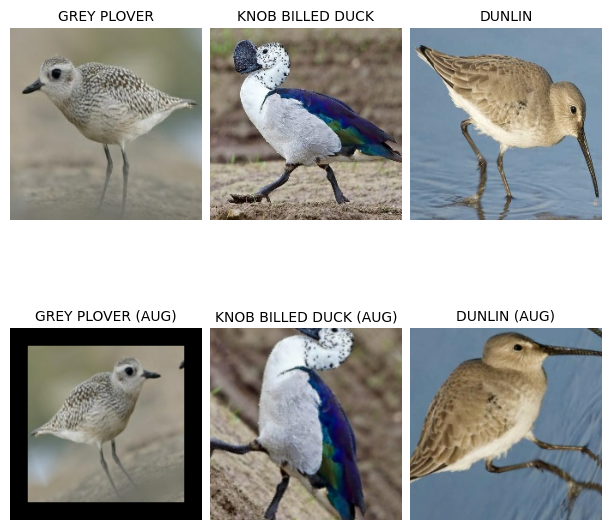

In [5]:
demo_num = 3

plt.figure()
fig, ax = plt.subplots(2, demo_num, figsize=(6, 6), layout="constrained")

for images, labels in train_set.take(1):
  augmented_images = data_augmentation(images)
  for i in range(demo_num):
    ax[0,i].set_title(class_names[labels[i]], fontsize=10)
    ax[0,i].imshow(images[i].numpy().astype("uint8"))
    ax[0,i].axis("off")
    ax[1,i].set_title(f'{class_names[labels[i]]} (AUG)', fontsize=10)
    ax[1,i].imshow(augmented_images[i].numpy().astype("uint8"))
    ax[1,i].axis("off")

## 建立模型

- lr_scheduler使用CosineDecay with Warmup，此方法參考自[EfficientNetV2 Paper](https://arxiv.org/pdf/2104.00298.pdf) 「5.2 Transfer Learning Datasets」。
- 參考資料：
    - [Google automl GitHub repo](https://github.com/google/automl/blob/master/efficientnetv2/datasets.py#L667)
    - [how-to-add-variables-to-progress-bar-in-keras](https://stackoverflow.com/questions/48198031/how-to-add-variables-to-progress-bar-in-keras/48206009#48206009)

In [6]:
from keras.applications import EfficientNetV2S
from keras.layers import GlobalAveragePooling2D, Dropout, Dense


def make_model(classes, input_shape):
    env2s = EfficientNetV2S(include_top=False,
                            weights="imagenet",
                            input_shape=input_shape,
                            include_preprocessing=True)
    env2s.trainable = False
    model = keras.Sequential(
        [
            keras.Input(input_shape),
            data_augmentation,
            env2s,
            GlobalAveragePooling2D(),
            Dropout(0.3),
            Dense(classes, activation="softmax")
        ]
    )
    return model


# optimizer:     Adam
# loss function: Crossentropy
# lr_scheduler:  CosineDecay with Warmup
train_epochs = 30
steps_per_epoch = train_set.cardinality().numpy().item()
lr_scheduler = keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.,
                                                      decay_steps=steps_per_epoch * train_epochs,
                                                      warmup_target=5e-3,
                                                      warmup_steps=steps_per_epoch * 2)
optimizer = keras.optimizers.Adam(learning_rate=lr_scheduler)

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

lr_metric = get_lr_metric(optimizer)

# 建立模型
model = make_model(len(class_names), image_size)
model.compile(optimizer=optimizer,
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy(name = 'accuracy'), lr_metric]
              )

## 檢查模型資訊

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 efficientnetv2-s (Function  (None, 7, 7, 1280)        20331360  
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 525)               672525    
                                                        

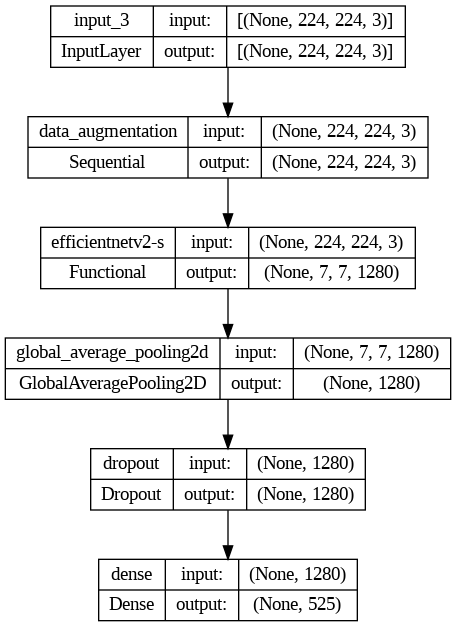

In [7]:
model.summary()
keras.utils.plot_model(model, show_shapes=True)

## 訓練模型

- 使用到的技巧
    - Early Stopping
    - Checkpoint (save best weight only)

In [8]:
# Early Stopping
earlystopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       patience=5)
# Checkpoint
checkpoint_path = f'{output_path}/checkpoint'
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                      monitor='val_loss',
                                                      mode='min',
                                                      save_best_only=True)
# 開始訓練
history = model.fit(train_set,
                    validation_data=valid_set,
                    epochs=train_epochs,
                    callbacks=[earlystopping_callback, checkpoint_callback])
# 載入最佳權重
model.load_weights(checkpoint_path)

Epoch 1/30
662/662 [==============================] - 432s 622ms/step - loss: 3.4661 - accuracy: 0.3687 - lr: 0.0012 - val_loss: 1.0536 - val_accuracy: 0.7749 - val_lr: 0.0025
Epoch 2/30
662/662 [==============================] - 409s 616ms/step - loss: 1.3217 - accuracy: 0.6797 - lr: 0.0037 - val_loss: 0.6012 - val_accuracy: 0.8377 - val_lr: 0.0050
Epoch 3/30
662/662 [==============================] - 412s 621ms/step - loss: 1.1395 - accuracy: 0.7136 - lr: 0.0050 - val_loss: 0.4628 - val_accuracy: 0.8724 - val_lr: 0.0050
Epoch 4/30
662/662 [==============================] - 416s 628ms/step - loss: 1.0792 - accuracy: 0.7325 - lr: 0.0050 - val_loss: 0.4148 - val_accuracy: 0.8770 - val_lr: 0.0049
Epoch 5/30
662/662 [==============================] - 499s 752ms/step - loss: 1.0439 - accuracy: 0.7426 - lr: 0.0049 - val_loss: 0.3849 - val_accuracy: 0.8853 - val_lr: 0.0049
Epoch 6/30
662/662 [==============================] - 540s 815ms/step - loss: 1.0369 - accuracy: 0.7493 - lr: 0.0048 - v

### 觀察Loss-Epoch和Accuracy-Epoch關係曲線

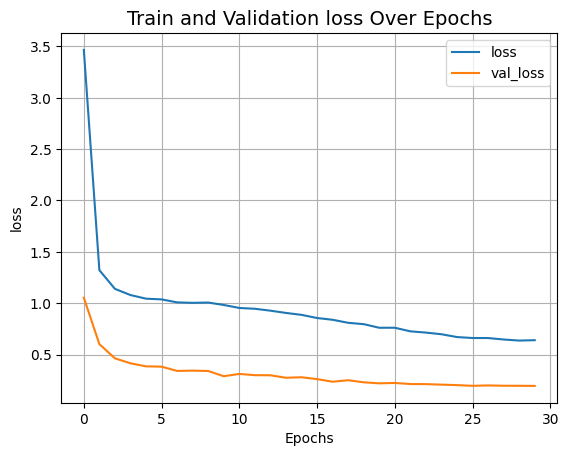

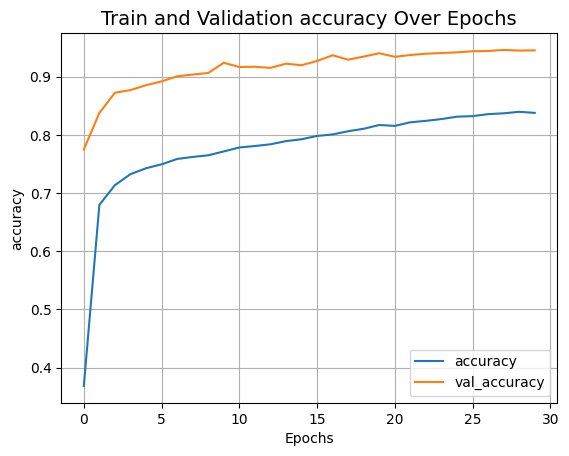

In [12]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("accuracy")

## 評估測試集

In [9]:
print('test set:')
test_set_eval = model.evaluate(test_set)

test set:
21/21 [==============================] - 10s 444ms/step - loss: 0.1944 - accuracy: 0.9451 - lr: 5.4713e-05


### 計算 Precision, Recall, F1-score

- 參考資料：
    - [How to get accuracy, F1, precision and recall, for a keras model?](https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-mode)

In [10]:
from sklearn.metrics import classification_report


y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_set:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch, verbose=False)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)


print(classification_report(correct_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.80      0.89         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      0.80      0.89         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       0.83      1.00      0.91         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       0.71      1.00      0.83         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         5
          17       1.00    

# 結束